# Yelp Restaurant Rating Prediction

## Project Description
The project goal is to explore, for restaurants in New York City, restaurant features' influence on ratings and predict restaurant's overall ratings on Yelp, using multiple features that we will
extract using the Yelp API. Our motivation is to help determine how
successful a new restaurant business might be, given certain known
characteristics of it.

We will use the Yelp API, with the help of pandas, to acquire raw data
from restaurants. Then we will extract reasonable features such as
location, open hours, whether it takes reservations, whether it has
delivery service, whether there is parking space, and whether it
provides free wifi etc., from the parsed data, and combine with the
overall ratings, which is a numerical value ranging across 1.0, 1.5, ... , 4.5, 5.0, as
labels.

We will analyze different features that
we extract and create on how much each of them shifts or affects the
distribution of ratings. Using our results from this we will select the important features
to train on machine learning models.

Using the labeled features that we construct, we will train different
machine learning models like nerual networks and logistic regression, then make some
predictions, and compare the accuracy obtained from them. We think predicting ratings with only the business features (so no review text) is naturally a difficult problem, but analyzing each feature's influence and making predictions on ratings could be hlepful for new restaurant business ideas.

## Team Members
Jun Hee Kim, Nikhil Rangarajan, Sander Shi

## Procedure
* [Data Gathering from API](#step-1)
* [Feature Extraction with Parsing](#step-2)
* [Feature Analysis and Variable Selection](#step-3)
* [Feature Engineering and Compression](#step-4)
* [Machine Learning Model Setup](#step-5)
* [Cross Validation](#step-6)
* [Prediction and Test Accuracy](#step-7)
* [Final Analysis](#step-8)

## Part 0: Imports and Definitions of Constants

We will be using `pandas` to parse the data and `tensorflow` to construct the machine learning models. We will also be using the Yelp API to gather the data. In order to
use the Yelp API, we need to create an API key to use in our API requests.

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import requests
import json
import time
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.neural_network import MLPClassifier
from collections import Counter
import scipy.stats as stats

API_URL = "https://api.yelp.com/v3/businesses"
SEARCH_URL = API_URL + "/search"
RESTAURANT_IDS = "rid.pkl"

with open("./API_KEY", 'r') as f:
    api_key = f.readline().strip()
API_HEADERS = {
    'Authorization': ' '.join(['Bearer', api_key])
}

<a id="step-1"></a>

## Part 1: Data Gathering from API

In this step we will use the Yelp API to gather restaurant pages, then extract
information using business search API requests.

Since the Yelp API will only allow us to load business information from up to 1000
distinct businesses on each search, we will first get the categories of the
restaurants, then perform a search query for each category.

In [2]:
def get_restaurant_categories(url):
    """
    This function gets all restaurant categories.
    
    @input url: URL to json file containing restaurant categories.
    @type url: String.
    
    @return: List of restaurant categories.
    @rtype: List of String
    """
    cats = json.load(open(url))
    return [cat['alias'] for cat in cats if 'restaurants' in cat['parents']]

categories = get_restaurant_categories('categories.json')
category_dict = {k: v for v, k in enumerate(categories)}

To aid feature creation for categories, we can write a function that maps every category
to a number.

In [3]:
def cat2num(category):
    """
    This function maps each category to a natural number to aid feature creation.
    
    @input category: A category.
    @type category: String.
    
    @return: An integer that the category is mapped to.
    @rtype: Integer.
    """
    return category_dict.get(category, (len(category_dict) + 1))

cat2num("italian")

92

Now that we have the restaurant categories, we can write a function to find all
restaurant IDs, and create a Pandas DataFrame. To aid debugging, we will dump
the dataframe into a pickle file so that we will not have to regenerate each time.

In [4]:
def get_req_json(url, params=None):
    """
    This function is a wrapper for a get request to the API.
    
    @input url: The API url.
    @type url: String.
    @input params: The parameters to pass to the get request.
    @type params: Dict.
    
    @return: A json response.
    @rtype: JSON
    """
    response = requests.get(url=url, headers=API_HEADERS, params=params)
    return response.json()


def find_restaurants(url, categories):
    """
    This function loads all restaurant data from restaurants in NYC.
    
    @input url: The API url.
    @type url: String.
    @input categories: The restaurant categories.
    @type categories: List of String.
    
    @return: A Pandas DataFrame containing the restaurant IDs.
    @rtype: pandas.DataFrame.
    """
    restaurants = []
    for cat in categories:
        params = {
            'term': 'restaurants',
            'location': 'NYC',
            'categories': cat
        }
        content = get_req_json(url, params)
        total = min(1000, content['total'])
        i = 0
        while i < total:
            limit = min(50, total - i)
            params['limit'] = limit
            params['offset'] = i
            content = get_req_json(url, params)
            restaurants.extend([b['id'] for b in content['businesses']])
            i += limit
    return pd.DataFrame({'id': list(set(restaurants))})

# Uncomment the following lines to get the restaurant IDs and recreate the pickle file.
# restaurants = find_restaurants(SEARCH_URL, categories)
# pickle.dump(restaurants, open(RESTAURANT_IDS, "wb"))

# Load restaurant IDs from pickle file
restaurant_ids = pickle.load(open(RESTAURANT_IDS, 'rb'))
restaurant_ids.tail()

,id
16076,kOFUrzoQPW6F0Bqllz5lpg
16077,bHQbqSRY8FDp7fQXPPzx1g
16078,s2xONRCHI08MISGZXzqBhA
16079,cevkTGf4vX_IBU_bGlz9ww
16080,MV39gToOLxzRdfuzzt-kUA


<a id="step-2"></a>

## Part 2: Feature Extraction with Parsing

Now that we have all the restaurant ids, in this step we can do a business lookup
to get the specific data of the restaurants.

In [5]:
def get_data(rids, api_url):
    """
    This function uses the Yelp business lookup API to get all data from each
    restaurant.
    
    @input api_url: The API url.
    @type api_url: String.
    @input rids: The dataframe containing all restaurant IDs.
    @type rids: pandas.DataFrame.
    
    @return: A list of restaurant information.
    @rtype: List of Json Object.
    """
    info = []
    for idx, rid in rids.iterrows():
        url = "/".join([api_url, rid['id']])
        content = get_req_json(url)
        info.append(content)
    return info

# Uncomment the following two lines to get the data from the API and save to pickle.
# all_data = get_data(restaurant_ids, API_URL)
# pickle.dump(all_data, open("restaurant_data.pkl", "wb"))

# Load all restaurant data from pickle file.
all_data = pickle.load(open("restaurant_data.pkl", 'rb'))
all_data[0]

{'alias': 'new-pizza-professor-brooklyn-brooklyn',
 'categories': [{'alias': 'pizza', 'title': 'Pizza'},
  {'alias': 'kosher', 'title': 'Kosher'}],
 'coordinates': {'latitude': 40.6184002, 'longitude': -73.9564177},
 'display_phone': '(347) 587-4277',
 'hours': [{'hours_type': 'REGULAR',
   'is_open_now': False,
   'open': [{'day': 0, 'end': '0200', 'is_overnight': True, 'start': '1100'},
    {'day': 1, 'end': '0200', 'is_overnight': True, 'start': '1100'},
    {'day': 2, 'end': '0200', 'is_overnight': True, 'start': '1100'},
    {'day': 3, 'end': '0200', 'is_overnight': True, 'start': '1100'},
    {'day': 4, 'end': '1445', 'is_overnight': False, 'start': '1100'},
    {'day': 5, 'end': '0300', 'is_overnight': True, 'start': '2030'},
    {'day': 6, 'end': '0200', 'is_overnight': True, 'start': '1100'}]}],
 'id': 'UTNSUIY2QW6RYNa0xLa9gg',
 'image_url': 'https://s3-media2.fl.yelpcdn.com/bphoto/zpkQadE2UF3DjvOBUHF9PA/o.jpg',
 'is_claimed': True,
 'is_closed': False,
 'location': {'address1

Using the data that we obtained from the API, we can extract useful information from it to build
a dataframe of features.

In [6]:
def extract_features(data):
    """
    This function creates a dataframe of features given a list of restaurant data.
    
    @input data: A list of restaurant data obtained from the Yelp API.
    @type api_url: List of JSON Object.
    
    @return: A Pandas DataFrame containing the restaurant features.
    @rtype: pandas.DataFrame.
    """
    prices, ratings, pickups, deliveries= [], [], [], []
    reservations, is_claimed, zipcodes, categories = [], [], [], []
    days = [2, 4, 5, 6]
    hours = dict()
    for day in days:
        hours[day] = []
    for content in (x for x in data if 'error' not in x):
        prices.append(len(content.get('price', "")))
        ratings.append(float(content.get('rating', 0)))
        transactions = content.get('transactions', [])
        pickups.append(int("pickup" in transactions))
        deliveries.append(int("delivery" in transactions))
        reservations.append(int("restaurant_reservation" in transactions))
        is_claimed.append(int(content.get('is_claimed', False)))
        if ('location' not in content) or ('zip_code' not in content['location']):
            zipcodes.append('00000')
        else:
            zc = content['location'].get('zip_code', '00000')
            zipcodes.append(zc if zc != '' else '00000')
        for day in days:
            if "hours" in content:
                open_hours = content["hours"][0]["open"]
                stats = [h for h in open_hours if h['day'] == day]
                is_overnight = int(True in [h['is_overnight'] for h in stats])
                start = min([h['start'] for h in stats], default='0000')
                end = max([h['end'] if h['end'] != '0000' else '2400' for h in stats], default='0000')
                hours[day].append([is_overnight, start, end])
            else:
                hours[day].append([0, '1200', '1800'])
        cat_list = [c['alias'] for c in content['categories']]
        categories.append(cat2num(np.random.choice(cat_list, 1)[0]))
        
    for day in days:
        hours[day] = np.array(hours[day])
        
    df_dict = {
        'price': prices,
        'category': categories,
        'pickup': pickups,
        'delivery': deliveries,
        'restaurant_reservation': reservations,
        'is_claimed': is_claimed,
        'zip_code': zipcodes,
        'rating': ratings,
        'wed_is_overnight': hours[2][:, 0].astype(int),
        'fri_is_overnight': hours[4][:, 0].astype(int),
        'sat_is_overnight': hours[5][:, 0].astype(int),
        'sun_is_overnight': hours[6][:, 0].astype(int),
        'wed_start': hours[2][:, 1],
        'fri_start': hours[4][:, 1],
        'sat_start': hours[5][:, 1],
        'sun_start': hours[6][:, 1],
        'wed_end': hours[2][:, 2],
        'fri_end': hours[4][:, 2],
        'sat_end': hours[5][:, 2],
        'sun_end': hours[6][:, 2]
    }
    return pd.DataFrame(df_dict).dropna(axis=0, how='any')

# Extract features from the loaded restaurant data
labeled_features = extract_features(all_data)
labeled_features.tail()

,category,delivery,fri_end,fri_is_overnight,fri_start,is_claimed,pickup,price,rating,restaurant_reservation,sat_end,sat_is_overnight,sat_start,sun_end,sun_is_overnight,sun_start,wed_end,wed_is_overnight,wed_start,zip_code
16071,191,0,2300,0,1100,0,0,2,3.5,0,2300,0,1100,2300,0,1100,2300,0,1100,11368
16072,161,0,1800,0,1200,0,0,2,3.0,0,1800,0,1200,1800,0,1200,1800,0,1200,10036
16073,191,1,2400,1,0000,0,1,2,3.0,0,2400,1,0000,2400,1,0000,2400,1,0000,11201
16074,93,1,1800,0,1200,0,1,2,3.5,0,1800,0,1200,1800,0,1200,1800,0,1200,07030
16075,37,1,2045,0,1200,1,1,0,4.5,0,2045,0,1200,2045,0,1200,2045,0,1200,10029


We have all the features of our restaurants now, so it is time to split it into
a training set for analysis and training and a test set for testing the accuracy.

In [7]:
def split_set(features, p_train=0.8):
    """
    This function splits all the data into a training set and a test set.
    
    @input features: The feature dataframe.
    @type features: pandas.DataFrame.
    @input p_train: The percentage of training data.
    @type p_train: Float.
    
    @return: Tuple of training and test set.
    @rtype: Tuple of pandas.DataFrame.
    """
    n = len(features)
    num_training = int(n * p_train)
    indices_perm = np.random.permutation(n)
    training_ind = indices_perm[:num_training]
    test_ind = indices_perm[num_training + 1:]
    training = features.iloc[training_ind]
    test = features.iloc[test_ind]
    return training.reset_index(drop=True), test.reset_index(drop=True)

training_features, test_features = split_set(labeled_features)
training_features.tail()

,category,delivery,fri_end,fri_is_overnight,fri_start,is_claimed,pickup,price,rating,restaurant_reservation,sat_end,sat_is_overnight,sat_start,sun_end,sun_is_overnight,sun_start,wed_end,wed_is_overnight,wed_start,zip_code
12855,191,0,2300,0,1100,1,0,3,3.5,0,2300,0,1000,2300,0,1000,2300,0,1100,10012
12856,40,1,2100,0,0730,1,1,2,3.5,0,1700,0,1100,1700,0,1100,2100,0,0730,10021
12857,93,0,2200,0,1200,1,0,4,3.5,0,2130,0,1730,0000,0,0000,2200,0,1200,10022
12858,22,0,2400,0,1200,1,0,2,4.5,0,2400,0,1200,2200,0,1200,2400,0,1700,10009
12859,151,0,2300,0,1200,1,0,3,4.0,0,2300,0,1200,1600,0,1200,2300,0,1200,10014


<a id="step-3"></a>

## Part 3: Feature Analysis and Variable Selection

Now that we have the features, we can separately analyse them and see how each feature
contributes to the rating.

### 1) Price
There are four levels (1, 2, 3, or 4) in price. Let's plot the frequency distribution of ratings for each price level to see if they differ alot, and then run an one-way ANOVA test to see if the population means of the ratings are different for at least two price levels.

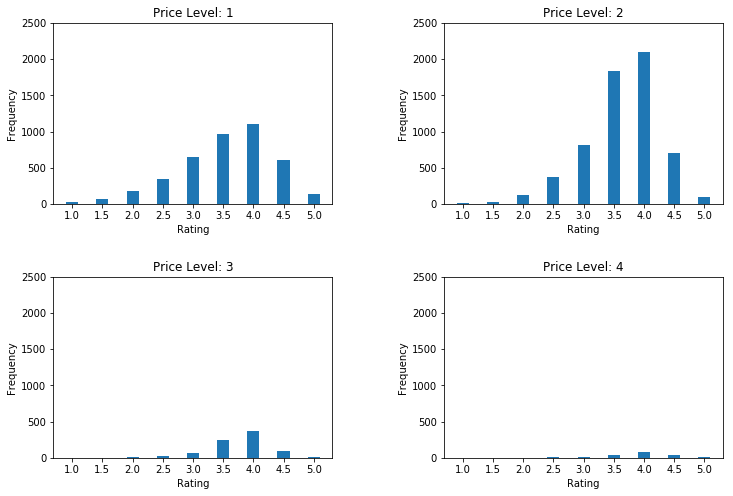

In [8]:
plt.rcParams["figure.figsize"] = [12,8]

def barplot_each_price(price_levels, rating, df, yaxis_same_range):
    """
    Input: 
    - price_levels is the list of possible price levels
    - rating is the list of possible ratings
    - df is the pandas dataframe containing the data
    
    This function plots the bar chart of the ratings for each of the price levels
    """
    for i in price_levels:
        price = i
        # ratings with this price level
        this_price_df = df.loc[df['price']==price]
        data = this_price_df['rating']
        counter = Counter(data)
        freq = [counter[rate] for rate in rating]
        plt.subplot(2,2,i)
        plt.subplots_adjust(hspace=0.4, wspace=0.4)
        plt.bar(rating, freq, width=0.2)
        plt.xlabel("Rating")
        plt.ylabel("Frequency")
        if (yaxis_same_range==True):
            plt.ylim(ymin=0, ymax=2500)
        plt.xticks(rating, rating)
        plt.title("Price Level: %s"%price)
    plt.show()

barplot_each_price(price_levels=[1,2,3,4], rating=np.linspace(1, 5, 9), df=training_features, yaxis_same_range=True)

We've set the y-axis range to be the same for all four subplots so that visually comparing becomes easier. The shapes of the rating frequencies appear very different. But such a visual impression might be due to the number of restaurants being so different for each price level rather than the distributions being different. In fact, the shapes don't differ too much if we don't restrict the y-axis ranges to be same across all subplots.

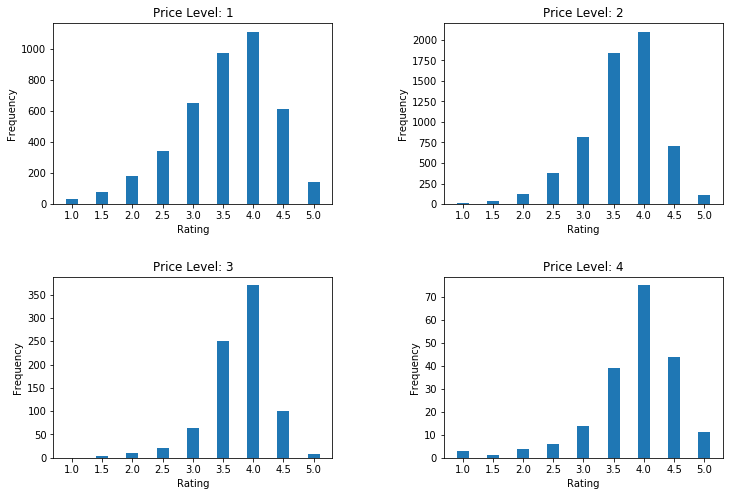

In [9]:
# Same plots, but we don't restrict y-axis ranges to be same
barplot_each_price(price_levels=[1,2,3,4], rating=np.linspace(1, 5, 9), df=training_features, yaxis_same_range=False)

So let's perform ANOVA to yield some formal conclusion.

In [10]:
def price_oneway_ANOVA(price_levels, df):
    """
    Input: 
    - price_levels is the list of possible price levels
    - df is the pandas dataframe containing the data
    
    This function returns the output of one-way ANOVA on ratings across different price levels
    """
    # This dictionary will have each key being each price level, and the corresponding value will be the array
    # of the ratings of the restaurants with that price level
    price_rating_dict = dict()
    for price in price_levels:
        this_price_df = df.loc[df['price']==price]
        price_rating_dict[price] = np.array(this_price_df['rating'])
    return stats.f_oneway(*price_rating_dict.values())

price_oneway_ANOVA(price_levels=[1,2,3,4], df=training_features)

F_onewayResult(statistic=35.75306785726932, pvalue=5.475907702752471e-23)

According to the ANOVA output, at $\alpha=0.01$, the p-value is less than $\alpha$, so we conclude at least two price levels have population rating means that are different. A limitation of one-way ANOVA is that we can't conclude which groups have different population rating means, but in our context, knowing that the rating means differ in at least two levels lets us conclude price is an important feature.

### 2) Transactions (Pickup, Delivery, Reservation)

We've parsed the transaction features as: "pickup" is 1 if pickup is available in that restaurant and 0 otherwise, and similarly for "delivery" and "restaurant_reservation". For each of the three transaction features, let's use two-sample t-test (one group of the restaurants that have that transaction, and the other group of those that don't) to determine if the two groups have differnt population rating means.

In [11]:
def two_sample_ttest(feature_name, values, df):
    """
    Input: 
    - feature_name is the name of the feature
    - values is the list of 2 possible values (which determine the 2 groups)
    - df is the pandas dataframe containing the data
    
    This function returns the output of one-way ANOVA on ratings across different price levels
    """
    feature_rating_dict = dict()
    for value in values:
        this_value_df = df.loc[df[feature_name]==value]
        feature_rating_dict[value] = np.array(this_value_df['rating'])
    return stats.ttest_ind(*feature_rating_dict.values(), equal_var=False)

transaction_vars = ['pickup', 'delivery', 'restaurant_reservation']
for feature in transaction_vars:
    print(feature, ":", two_sample_ttest(feature_name=feature, values=[0,1], df=training_features))

pickup : Ttest_indResult(statistic=2.5851871291532342, pvalue=0.009743561364712163)
delivery : Ttest_indResult(statistic=4.402963440099755, pvalue=1.0764457716794771e-05)
restaurant_reservation : Ttest_indResult(statistic=-13.116420705078784, pvalue=9.71715118025298e-38)


According to the t-test output, for each of the three transaction features, at $\alpha=0.01$, the p-value is less than $\alpha$, so we conclude the two groups have population rating means that are different. One might think that all three features should be included in the model.

But common sense tells us there might be correlations among the transaction features, and in general, correlated features can cause problems in modeling (e.g. multicollinearity problem in non-regularized linear regression). Let's examine the correlation coefficient for each pair among the three.

In [12]:
def print_pcc(list_vars, df):
    """
    Input
    - list_vars is the list of feature names in which the Pearson Correlation Coefficient for each pair is computed
    - df is the pandas dataframe containing the data
    
    This function prints the Pearson Correlation Coefficient for each pair of the features provided in the list
    """
    for i in range(0, len(list_vars)):
        for j in range(i+1, len(list_vars)):
            corr = np.corrcoef(df[list_vars[i]], df[list_vars[j]])[0,1]
            print(list_vars[i],  ",", list_vars[j], corr)

print_pcc(transaction_vars, df=training_features)

pickup , delivery 0.9316230904767052
pickup , restaurant_reservation 0.1117265966770224
delivery , restaurant_reservation 0.09580199427887531


Pickup and delivery are highly correlated, but the other two pairs are fine. So among the three, we decide to include reservation and only one of pickup and delivery. Between the two correlated features, we choose delivery since its t-test p-value is lower than pickup's.

### 3) Zip Code

Let's plot a bubble plot of the ratings and zip codes.

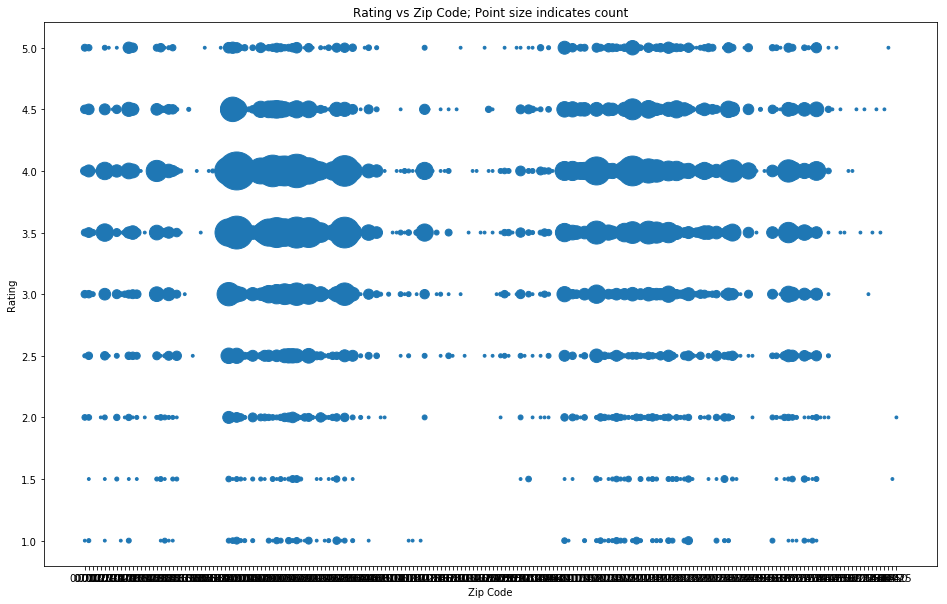

In [13]:
plt.rcParams["figure.figsize"] = [16,10]

def bubbleplot_two_vars(var1, var2, df, xlabel="Zip Code", ylabel="Rating"):
    """
    Input
    - var1 is the name of the first variable (which is a column in the dataframe)
    - var2 is the name of the second variable (which is a column in the dataframe)
    - df is the dataframe containing the data
    
    This function plots a bubble plot of the two variables in the dataframe
    """
    pairs = np.array(df[[var1, var2]]).astype(str)
    label_x, x = np.unique(pairs[:,0], return_inverse=True)
    label_y, y = np.unique(pairs[:,1], return_inverse=True)
    xy, cnts = np.unique((x,y), axis=1, return_counts=True)
    plt.scatter(xy[0], xy[1], s=cnts*8)
    plt.xlabel("Zip Code")
    plt.ylabel("Rating")
    plt.title("%s vs %s; Point size indicates count"%(ylabel, xlabel))
    plt.xticks(range(len(label_x)), label_x)
    plt.yticks(range(len(label_y)), label_y)
    plt.show()

bubbleplot_two_vars(var1='zip_code', var2='rating', df=training_features)

We can see that in some zip codes, the ratings of 4.0 and 3.5 are clearly dominant, while for other zip codes, all the ratings are similarly frequent. This plot suggests that ratings do differ for different zip codes.

Now, let's perform one-way ANOVA on the zip codes to check if at least two zip codes have different population mean of ratings. Few rows in our dataframe have missing zip code information and have them recorded as "00000". So we exclude them when performing ANOVA.

In [14]:
def zipcode_oneway_ANOVA(zipcodes, df):
    """
    Input: 
    - zipcodes is the list of zip codes
    - df is the pandas dataframe containing the data
    
    This function returns the output of one-way ANOVA on ratings across different zip codes
    """
    # This dictionary will have each key being each zip code, and the corresponding value will be the array
    # of the ratings of the restaurants with that zip code
    zipcode_rating_dict = dict()
    for zipcode in zipcodes:
        this_zipcode_df = df.loc[df['zip_code']==zipcode]
        zipcode_rating_dict[zipcode] = np.array(this_zipcode_df['rating'])
    return stats.f_oneway(*zipcode_rating_dict.values())

unique_zipcodes = training_features['zip_code'].unique()
unique_zipcodes = unique_zipcodes[unique_zipcodes != "00000"]
print("Number of unique zip codes in dataset:", len(unique_zipcodes))
zipcode_oneway_ANOVA(zipcodes=unique_zipcodes, df=training_features)

Number of unique zip codes in dataset: 203


F_onewayResult(statistic=4.058464147877502, pvalue=3.6078913980144963e-72)

This result indicates at least two zip codes have dfferent populationr rating means. But since there are so many unique zip codes in our data, this result is not very informative. We could try performing two-sample t-test for every unordered pair of zip codes, but a better way would be to map each zip code to one of the five boroughs in NYC and do analysis.

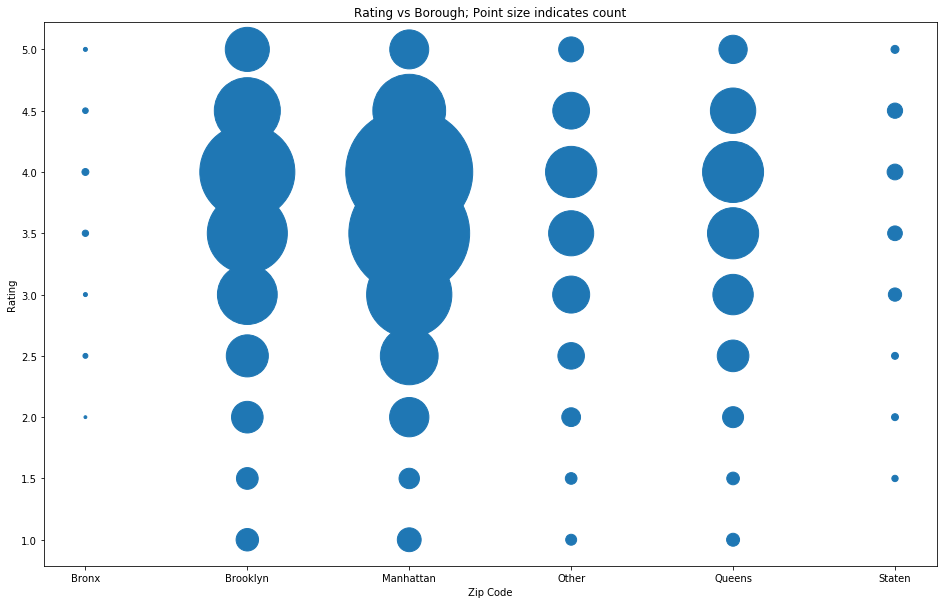

In [15]:
plt.rcParams["figure.figsize"] = [16,10]

# Map zipcode to borough
# Preprocessed based on https://www.nycbynatives.com/nyc_info/new_york_city_zip_codes.php
boroughs = []
zipcode_borough_dict = np.load('zipcode_borough_dict.npy').item()
for zipcode in training_features['zip_code']:
    if zipcode in zipcode_borough_dict.keys():
        boroughs.append(zipcode_borough_dict[zipcode])
    else:
        boroughs.append("Other")
temp_df = pd.DataFrame()
temp_df['rating'] = training_features['rating']
temp_df['borough'] = boroughs
bubbleplot_two_vars(var1='borough', var2='rating', df=temp_df, xlabel="Borough", ylabel="Rating")

For Brooklyn and Manhattan, ratings of 4.0 and 3.5 are clearly dominant, while for other boroughs, that dominance is relatively moderate. Let's perform one-way ANOVA on these six levels of borough.

In [16]:
def borough_oneway_ANOVA(boroughs, df):
    """
    Input: 
    - boroughs is the list of boroughs
    - df is the pandas dataframe containing the data
    
    This function returns the output of one-way ANOVA on ratings across different boroughs
    """
    # This dictionary will have each key being each borough, and the corresponding value will be the array
    # of the ratings of the restaurants in that borough
    borough_rating_dict = dict()
    for borough in boroughs:
        this_borough_df = df.loc[df['borough']==borough]
        borough_rating_dict[borough] = np.array(this_borough_df['rating'])
    return stats.f_oneway(*borough_rating_dict.values())

borough_oneway_ANOVA(boroughs=["Manhattan", "Bronx", "Staten", "Queens", "Brooklyn", "Other"], df=temp_df)

F_onewayResult(statistic=5.217795742679986, pvalue=8.666022435197824e-05)

According to the ANOVA output, at $\alpha=0.01$, the p-value is less than $\alpha$, so we conclude at least two boroughs have population rating means of restaurants that are different, and so we consider borough an important feature. We'd have to add such features in the feature engineering in the next part.

### 4) Claimed

A claimed business page in Yelp is one that has been claimed by the owner or representative of the business through our verification process. Let's plot the frequency of ratings for the claimed restaurants and that for nonclaimed restaurants, and then perform two-sample t-test.

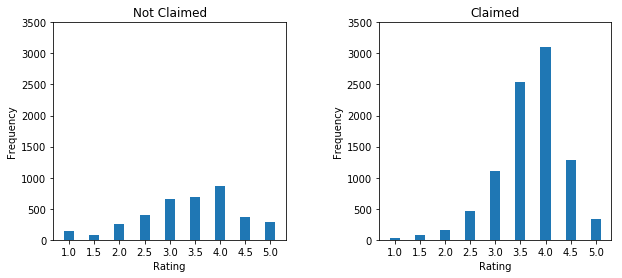

In [17]:
plt.rcParams["figure.figsize"] = [10,4]

def barplot_claimed(rating, df, yaxis_same_range):
    """
    Input: 
    - rating is the list of possible ratings
    - df is the pandas dataframe containing the data
    
    This function overplots the bar chart of the ratings for restaurants claimed and those that are not.
    """
    for i in [0,1]:
        subplot_index = i + 1
        # ratings of claimed restaurants
        this_price_df = df.loc[df['is_claimed']==i]
        data = this_price_df['rating']
        counter = Counter(data)
        freq = [counter[rate] for rate in rating]
        plt.subplot(1,2,subplot_index)
        plt.subplots_adjust(hspace=0.4, wspace=0.4)
        plt.bar(rating, freq, width=0.2)
        plt.xlabel("Rating")
        plt.ylabel("Frequency")
        if (yaxis_same_range==True):
            plt.ylim(ymin=0, ymax=3500)
        plt.xticks(rating, rating)
        plt.title("Claimed" if i==1 else "Not Claimed")
    plt.show()

barplot_claimed(rating=np.linspace(1, 5, 9), df=training_features, yaxis_same_range=True)

The bar charts suggest that the frequencies are considerably different, especially in terms of how dominantly frequent ratings of 3.5 or 4 are. But again, the shapes are not horribly different once we don't set the y-axis ranges equally.

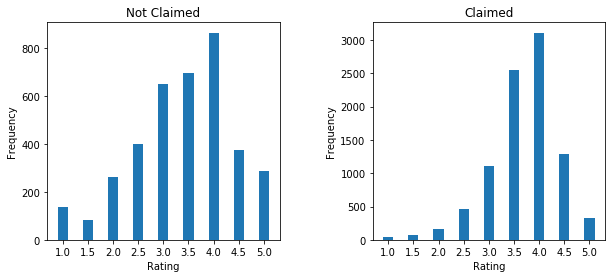

In [18]:
# Same plots, but we don't restrict the y-axis ranges to be the same
barplot_claimed(rating=np.linspace(1, 5, 9), df=training_features, yaxis_same_range=False)

Let's perform two-sample t-test.

In [19]:
two_sample_ttest(feature_name='is_claimed', values=[0,1], df=training_features)

Ttest_indResult(statistic=-17.73344307005918, pvalue=2.164960841729894e-68)

According to the t-test output, at $\alpha=0.01$, the p-value is less than $\alpha$, so we conclude the two groups have population rating means that are different and thus treat whether or not the restaurant is claimed as a meaningful feature.

### 5) Hours

There are 4 different days that we are taking into consideration - Wednesday, Friday, Saturday and Sunday. 

For each one of these individual days, we are analyzing how ratings are influenced based on whether the restaurant is in service overnight or not. 

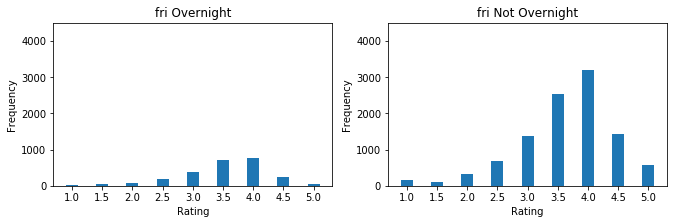

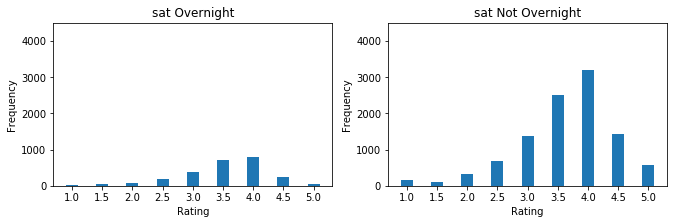

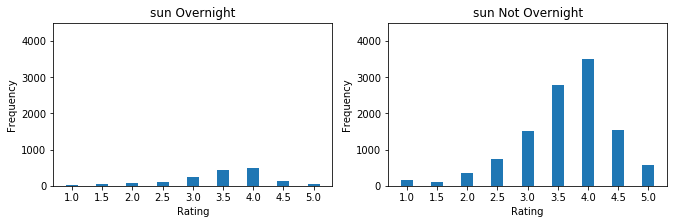

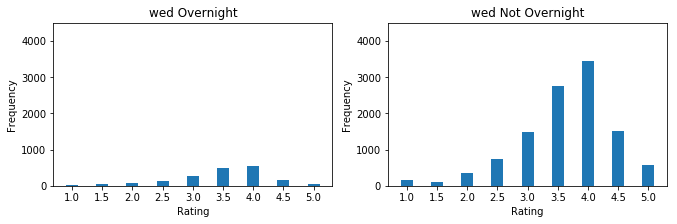

In [20]:
plt.rcParams["figure.figsize"] = [11,3]

def barplot_overnight(rating, df):
    """
    Input: 
    - rating is the list of possible ratings
    - df is the pandas dataframe containing the training data
    
    This function plots the bar chart of the ratings for each of the days (overnight or not)
    """
    # Days that are taken into consideration
    days = ["fri", "sat", "sun", "wed"]
    for day in days:
        overnight_index = day + "_is_overnight"
        overnight_day_df = df[[overnight_index, "rating"]]
        is_overnight = overnight_day_df[overnight_day_df[overnight_index] == 1]
        is_not_overnight = overnight_day_df[overnight_day_df[overnight_index] == 0]
        # Initialize counters
        counter_overnight = Counter(is_overnight["rating"])
        counter_not_overnight = Counter(is_not_overnight["rating"])
        freq_night = [counter_overnight[rate] for rate in rating]
        freq_not_night = [counter_not_overnight[rate] for rate in rating]  
        # Plotting
        plt.subplot(1, 2, 1)
        plt.bar(rating, freq_night, width = 0.2)
        plt.xlabel("Rating")
        plt.ylabel("Frequency")
        plt.ylim(ymin=0, ymax=4500)
        plt.xticks(rating, rating)
        plt.title("%s Overnight"%day)
        plt.subplot(1, 2, 2)
        plt.bar(rating, freq_not_night, width = 0.2)
        plt.xlabel("Rating")
        plt.ylabel("Frequency")
        plt.ylim(ymin=0, ymax=4500)
        plt.xticks(rating, rating)
        plt.title("%s Not Overnight" %day)   
        plt.show()
        
rating=np.linspace(1, 5, 9)
barplot_overnight(rating, training_features)

In [21]:
overnight_vars = ["fri_is_overnight", "sat_is_overnight", "sun_is_overnight", "wed_is_overnight"]
for feature in overnight_vars:
    print(feature, ":", two_sample_ttest(feature_name=feature, values=[0,1], df=training_features))

fri_is_overnight : Ttest_indResult(statistic=6.272600050920771, pvalue=3.933991733197661e-10)
sat_is_overnight : Ttest_indResult(statistic=6.271183101775557, pvalue=3.9584838423245066e-10)
sun_is_overnight : Ttest_indResult(statistic=7.445902993292055, pvalue=1.4071641284669857e-13)
wed_is_overnight : Ttest_indResult(statistic=7.050273560261987, pvalue=2.324244234774158e-12)


The t-tests suggest for all 4 days of the week, overnight restaurants and non-overnight restaurants have different population mean ratings. But let's examine the correlations across the 4 days.

In [22]:
print_pcc(overnight_vars, df=training_features)

fri_is_overnight , sat_is_overnight 0.9781948617249728
fri_is_overnight , sun_is_overnight 0.7452756770008995
fri_is_overnight , wed_is_overnight 0.8037355325123406
sat_is_overnight , sun_is_overnight 0.7527003008647
sat_is_overnight , wed_is_overnight 0.7974385980286419
sun_is_overnight , wed_is_overnight 0.8992279619540039


All pairs have very high correlations, so let's choose the two days that have the lowest correlation. That is: the overnight feature for only Firday and Sunday will be included.

Additionally, we are also interested in how long a particular restaurant is open on these 4 sets of days. 
We plot a scatter plot based on the ratings and how long a restaurant is open. 

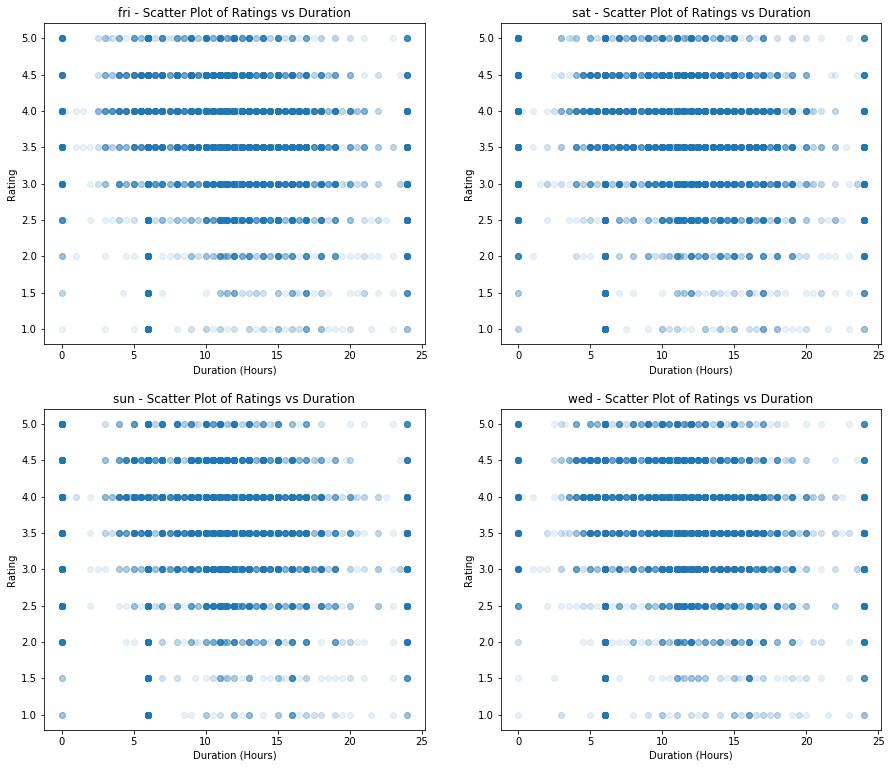

In [23]:
def convert(string):
    """
    Convert a time string into minutes
    """
    hour = int(string[0:2])
    minutes = int(string[2:])
    return hour*60 + minutes
    
def next_day(diff):
    """
    Return number of hours if restaurant closes past midnight
    """
    if (diff < 0):
        return 24*60 + diff
    return diff

def scatterplot_duration(rating, df):
    """
    Input: 
    - rating is the list of possible ratings
    - df is the pandas dataframe containing the training data
    
    This function plots the bar chart of the ratings for each of the days (overnight or not)
    """
    # Days that are taken into consideration
    days = ["fri", "sat", "sun", "wed"]
    i = 1
    for day in days:
        start_i = day + "_start"
        end_i = day + "_end"
        start = df[start_i].apply(convert)
        end = df[end_i].apply(convert)
        duration = ((end - start).apply(next_day)) / 60
        plt.rcParams["figure.figsize"] = [15,13]
        plt.subplot(2, 2, i)
        i += 1
        plt.scatter(duration, df["rating"], alpha = 0.1)
        plt.yticks(rating, rating)
        plt.ylabel("Rating")
        plt.xlabel("Duration (Hours)")
        plt.title("%s - Scatter Plot of Ratings vs Duration" %day)
    plt.show()
    
rating = np.linspace(1, 5, 9) 
scatterplot_duration(rating, training_features)

The plots suggest different durations have different distributions of ratings. But again, let's examine correlations.

In [24]:
days = ["fri", "sat", "sun", "wed"]
temp_df = pd.DataFrame()
for day in days:
    start_i = day + "_start"
    end_i = day + "_end"
    dur_i = day + "_duration"
    start = training_features[start_i].apply(convert)
    end = training_features[end_i].apply(convert)
    temp_df[dur_i] = ((end - start).apply(next_day))/60

duration_vars = ["fri_duration", "sat_duration", "sun_duration", "wed_duration"]
print_pcc(duration_vars, df=temp_df)

fri_duration , sat_duration 0.8707660209935308
fri_duration , sun_duration 0.7295400210598572
fri_duration , wed_duration 0.9212493105297549
sat_duration , sun_duration 0.8271859087869838
sat_duration , wed_duration 0.7927046306213645
sun_duration , wed_duration 0.7365298145532125


Again, all pairs have very high correlations, so let's choose the two days that have the lowest correlation. That is: the duration feature for only Firday and Sunday will be included. We'd have to add such features in the feature engineering in the next part.

### 6) Category

Lastly, we analyze the restaurant categories. Let's draw a side-by-side boxplot of ratings for each category.

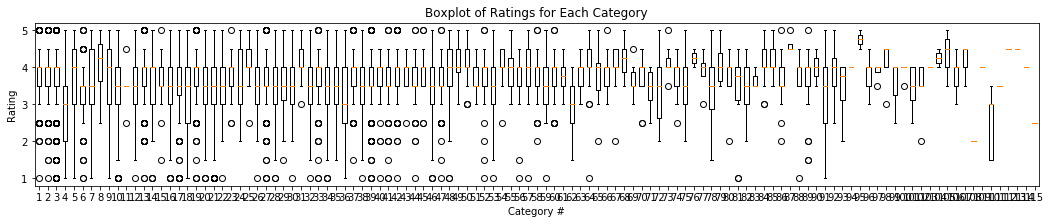

In [25]:
plt.rcParams["figure.figsize"] = [18,3]

def boxplot_each_category(df):
    """
    Input
    - df is the Pandas dataframe containing the data
    
    This function plots a side-by-side boxplot of ratings for each restaurant category in the dataframe
    """
    unique_categs = df['category'].unique()
    boxplot_input = [list(df.loc[df['category']==categ]['rating']) for categ in unique_categs]
    plt.boxplot(boxplot_input)
    plt.xlabel("Category #")
    plt.ylabel("Rating")
    plt.title("Boxplot of Ratings for Each Category")
    plt.show()
    
boxplot_each_category(df=training_features)

Though the plot looks crowded due to the large number of categories, if we focus on the orange lines which are the means, we can see that the rating means are clearly different across different categories.

Unlike the zip code feature which was straighforward to map to fewer number of groups (we used boroughs using actual geographical information), there is no clear way (according to common sense) to map the 115 restaurant categories into smaller groups. Moreover, some restaurants can have multiple categories in the Yelp API output (though in the dataframe we've explored so far, we just randomly chose one category in such cases), and we thought for such restaurants, somehow maintaining all those categories is important. These thoughts made us decide to use all the categories as possible levels of the category feature, specifically using the one-hot encoding approach (115 binary features, each representing one category, and each restaurant has 1 in all the category features corresponding to its category(ies), and 0 in all other category features). We'd have to add such features in the feature engineering in the next part.

Note: We're not using the dummy variable approach (if k possible levels, then create k-1 binary features with one baseline level m so that a datapoint with level m of that feature has 0 in all those k-1 features) as we will for boroughs because a restaurant can have multiple categories.

<a id="step-4"></a>

## Part 4: Feature Engineering and Compression

After our analyses on the raw features we obtained from the API, we can choose
which features to use and how to use them.

In [41]:
def one_hot_encode(labels):
    """
    This function gives a one-hot encoding of the rating labels.
    
    @input labels: An array-like object of ratings.
    @type labels: numpy.ndarray or list.
    
    @return: A one-hot encoding of the labels.
    @rtype: numpy.ndarray.
    """
    ratings = np.linspace(1, 5, 9)
    return np.array([(r == ratings).astype(int) for r in labels])

def convert(string):
    """
    Convert a time string into minutes.
    
    @input string: A string of a 24-hour time.
    
    @return: The raw minutes conversion of the string.
    @rtype: int
    """
    hour = int(string[0:2])
    minutes = int(string[2:])
    return hour*60 + minutes

def convert_to_min(column):
    """
    Apply the convert function on a pandas column.
    
    @input column: A column containing strings of 24-hour times.
    @type column: pandas.Series
    
    @return: The conversion of 24-hour times to raw minutes in the column
    @rtype: pandas.Series
    """
    return column.apply(convert)

def get_minutes(df):
    """
    Add minutes column to a dataframe based on start and end times.
    
    @input df: Dataframe of features.
    @type df: pandas.DataFrame
    
    @return: The updated dataframe containing updated columns of raw minutes.
    @rtype: pandas.DataFrame
    """
    days = ["fri", "sat", "sun", "wed"]
    for day in days:
        df[day + "_min_start"] = convert_to_min(df[day + "_start"])
        df[day + "_min_end"] = convert_to_min(df[day + "_end"])
    return df
        
        
        
def compress_features(features):
    """
    This function takes a feature dataframe and outputs a corresponding
    numpy array of features.
    
    @input features: Dataframe of features.
    @type features: pandas.DataFrame.
    
    @return: a design matrix of floats.
    @rtype: numpy.ndarray of float.
    """
    features = get_minutes(features)
    y = one_hot_encode(np.array(features['rating']))
    X = np.array(features.drop(['rating'], axis=1)).astype(float)
    return X, y

X_train, y_train = compress_features(training_features)
X_test, y_test = compress_features(test_features)

<a id="step-5"></a>

## Part 5: Machine Learning Model Setup

We need to construct a couple machine learning models for us to train to see which
one gives us the best testing accuracy.

We will first build a neural network.

In [26]:
class ANN(object):
    """
    This is a neural network.
    """
    def __init__(self, layers=[5, 5]):
        self.layers = layers

Now we will build a logistic regression classifier.

In [27]:
class LogisticRegression(object):
    """
    This is the logistic regression model.
    """
    def __init__(self):
        self.theta = np.zeros(100)

<a id="step-6"></a>

## Part 6: Cross Validation

Now we will use cross-validation to determine which model produces the highest
validation accuracy for our dataset, then pick this model.

In [28]:
def pick_model():
    pass

<a id="step-7"></a>

## Part 7: Prediction and Test Accuracy

In [29]:
def calculate_accuracy():
    pass

<a id="step-8"></a>

## Part 8: Final Analysis

Our results were amazing, so yeah.